# Assignment 4 - Data Set Description
The questions below relate to the data files associated with the contest with the title 'DengAI: Predicting Disease Spread' published at the following website. 
https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/data/

Anyone can join the contest and showcase your skills. To know about contest submissions visit the following webpage
https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/submissions/
You can showcase your Machine Learning skills by ranking top in the contest. 

Problem description:
Your goal is to predict the total_cases label for each (city, year, weekofyear) in the test set. There are two cities, San Juan and Iquitos, with test data for each city spanning 5 and 3 years respectively. You will make one submission that contains predictions for both cities. The data for each city have been concatenated along with a city column indicating the source: sj for San Juan and iq for Iquitos. The test set is a pure future hold-out, meaning the test data are sequential and non-overlapping with any of the training data. Throughout, missing values have been filled as NaNs.

Assignment:
The goal is achieved through three subsequent Assignments 1, 2, 3 and 4, all using the same dataset


The features in this dataset
You are provided the following set of information on a (year, weekofyear) timescale:

(Where appropriate, units are provided as a _unit suffix on the feature name.)

City and date indicators

    city – City abbreviations: sj for San Juan and iq for Iquitos
    week_start_date – Date given in yyyy-mm-dd format

NOAA's GHCN daily climate data weather station measurements

    station_max_temp_c – Maximum temperature
    station_min_temp_c – Minimum temperature
    station_avg_temp_c – Average temperature
    station_precip_mm – Total precipitation
    station_diur_temp_rng_c – Diurnal temperature range
    
PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)

    precipitation_amt_mm – Total precipitation

NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)

    reanalysis_sat_precip_amt_mm – Total precipitation
    reanalysis_dew_point_temp_k – Mean dew point temperature
    reanalysis_air_temp_k – Mean air temperature
    reanalysis_relative_humidity_percent – Mean relative humidity
    reanalysis_specific_humidity_g_per_kg – Mean specific humidity
    reanalysis_precip_amt_kg_per_m2 – Total precipitation
    reanalysis_max_air_temp_k – Maximum air temperature
    reanalysis_min_air_temp_k – Minimum air temperature
    reanalysis_avg_temp_k – Average air temperature
    reanalysis_tdtr_k – Diurnal temperature range

Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements

    ndvi_se – Pixel southeast of city centroid
    ndvi_sw – Pixel southwest of city centroid
    ndvi_ne – Pixel northeast of city centroid
    ndvi_nw – Pixel northwest of city centroid

# Assignment 4 - Questions
Use the merged data frame from Assignment 1,2  and 3 for this assignment

This Assignment focuses on data preprocessing and model building. Continue with the datasets loaded in Assignment 1, 2 and 3 (or reload with same steps and create merged data frame). In this assignment you need to use Neural Network

1. Load the data (both features and label data set as before)
2. Preprocess the data - briefly comment if any special preprocessing is adopted to suit Neural Network



Submit the .ipynb, and .html (optional submission.csv if you performed MLP regressor)


In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [138]:
#import the data
df=pd.read_csv("C:/Users/18132/Desktop/My Docs/DSP/Ass_3/df_merged.csv")

In [139]:
#Removing the outliers using inter-quantiles
Q1=df['total_cases'].quantile(0.25)
Q3=df['total_cases'].quantile(0.75)
IQR=Q3-Q1
print(IQR)
df_out=pd.DataFrame()
df_out=df[(df['total_cases']<(Q1-1.5*IQR))|(df['total_cases']>(Q3+1.5*IQR))]
print(df_out.shape)

23.0
(124, 25)


In [140]:
df_noout=df[~((df['total_cases']<(Q1-1.5*IQR))|(df['total_cases']>(Q3+1.5*IQR)))]
df_noout.shape

(1332, 25)

In [141]:
#Checking if we have nans
df_noout.isna().sum()

city                          0
year                          0
weekofyear                    0
week_start_date               0
ndvi_ne                       0
ndvi_nw                       0
ndvi_se                       0
ndvi_sw                       0
prec_amt_mm                   0
re_an_air_temp_k              0
re_an_avg_temp_k              0
re_an_dew_point_temp_k        0
re_an_max_air_temp_k          0
re_an_min_air_temp_k          0
re_an_precip_amt_kg_per_m2    0
re_an_relative_hd_percent     0
re_an_sat_precip_amt_mm       0
re_an_specific_hd_g_per_kg    0
re_an_tdtr_k                  0
stn_avg_temp_c                0
stn_diur_temp_rng_c           0
stn_max_temp_c                0
stn_min_temp_c                0
stn_precip_mm                 0
total_cases                   0
dtype: int64

In [142]:
#As correlation don't run for strings and also there is no point to check correlation of year and 
#week of year with other variables,as they are not integer values , but kind of factor variables, so we removed it and create a dataset
df_new=df_noout.drop(columns=['city','week_start_date','year','weekofyear'])

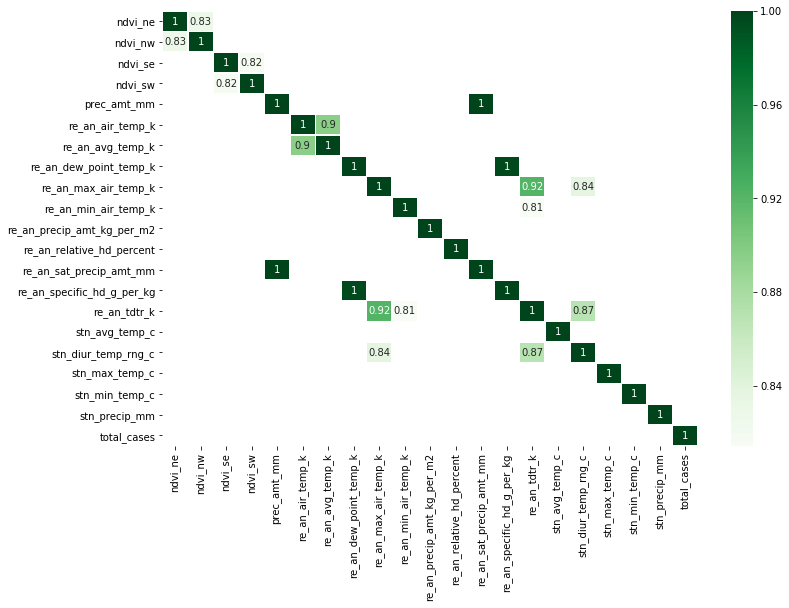

In [143]:
corr = df_new.corr().abs() #Calculate correlation and convert them to positive for plot
c = corr[corr>=.8] #Take only highly correlated values, i.e. more than 0.8
plt.figure(figsize=(12,8)) #Set the size of figure
sns.heatmap(c,annot=True, cmap="Greens",linewidths=.5) #Create correlation plot using heatmap

From the above plot, we can see the variables which are highly correlated, so we can do feature selection based on this:

1.ndvi_nw: Considered this between ndvi_nw and ndvi_ne, as both are highly correlated, so will keep one, also its near by direction, it might have same pixels.

2.ndvi_sw: Considered this between ndvi_sw and ndvi_se, as both are highly correlated, so will keep one, also its near by direction, it might have same pixels.

3.re_an_air_temp: Considered this between re_an_air_temp and re_an_avg_temp_k, as both are highly correlated and also both specify average air temperature.

4.re_an_tdtr_k: Considered this, as it is highly correlated with re_an_min_air_temp_k, re_an_max_air_temp_k,stn_diur_temp_rng_c, also as we know diurnal temperature is difference of minimum and maximyum temperature.

5.re_an_sat_precip_amt_mm: Considered this between re_an_sat_precip_amt_mm and prec_amt_mm, as they are highly correlated and also both are displaying the same values.

6.re_an_specific_hd_g_per_kg:Considered this between re_an_specific_hd_g_per_kg and re_an_dew point_temp_k, as they are highly correlated and also both of them refer to water vapour in environment.

7.re_an_precip_amt_kg_per_m2: Considered as it is not highly correlated with any variable

8.re_an_relative_hd_percent:Considered, as not highly correlated with any variable, also it represents vapour to vapour and to dry air like specific humidity.

9.Considered stn_avg_temp_c, stn_max_temp_c,stn_min_temp_c and stn_percip_mm, as none of them are highly correlated with other variables.

10.week_start_date: We are not considering week_start_date, as we can get the same value by using the combination of week_of_year and year, so will kepp these two instead of week_start_date.



In [144]:
#Dataframe with selected variable
df_sel=df_noout.drop(columns=['ndvi_ne','ndvi_se','re_an_avg_temp_k','re_an_min_air_temp_k','re_an_max_air_temp_k','stn_diur_temp_rng_c','prec_amt_mm','re_an_dew_point_temp_k','week_start_date'])
df_sel.shape

(1332, 16)

#Convert column with percentage to value/100

In [145]:
df_sel['re_an_relative_hd_percent']=(df_sel['re_an_relative_hd_percent']/ 100).round(2)

#Scale the vegetation features (ndvi*) as 0, 1 (0 <= 0.25 and 1 > 0.25) as it is in scale of 0 to 0.5

In [146]:
df_sel.loc[df_sel['ndvi_nw']<=0.25,'sc_ndvi_nw']=0
df_sel.loc[df_sel['ndvi_nw']>0.25,'sc_ndvi_nw']=1
df_sel.loc[df_sel['ndvi_sw']<=0.25,'sc_ndvi_sw']=0
df_sel.loc[df_sel['ndvi_sw']>0.25,'sc_ndvi_sw']=1

In [147]:
df_sel=df_sel.drop(columns=['ndvi_nw','ndvi_sw'])

In [148]:
df_sel.head()

,city,year,weekofyear,re_an_air_temp_k,re_an_precip_amt_kg_per_m2,re_an_relative_hd_percent,re_an_sat_precip_amt_mm,re_an_specific_hd_g_per_kg,re_an_tdtr_k,stn_avg_temp_c,stn_max_temp_c,stn_min_temp_c,stn_precip_mm,total_cases,sc_ndvi_nw,sc_ndvi_sw
0,sj,1990,18,297.572857,32.00,0.73,12.42,14.012857,2.628571,25.442857,29.4,20.0,16.0,4,0.0,0.0
1,sj,1990,19,298.211429,17.94,0.77,22.82,15.372857,2.371429,26.714286,31.7,22.2,8.6,5,0.0,0.0
2,sj,1990,20,298.781429,26.10,0.82,34.54,16.848571,2.300000,26.714286,32.2,22.8,41.4,4,0.0,0.0
3,sj,1990,21,298.987143,13.90,0.80,15.36,16.672857,2.428571,27.471429,33.3,23.3,4.0,3,0.0,0.0
4,sj,1990,22,299.518571,12.20,0.80,7.52,17.210000,3.014286,28.942857,35.0,23.9,5.8,6,1.0,0.0


**3. Optional: Build a Neural Network Multi-Layer Perceptron Regressor model (you can use sklearn neural network MLP Regressor)**

In [149]:
df_reg=df_sel

#Checking the maximum datapoints around which value by using histogram, so that we can create the stratified split accordingly

Text(0.5, 1.0, 'Histogram of total cases')

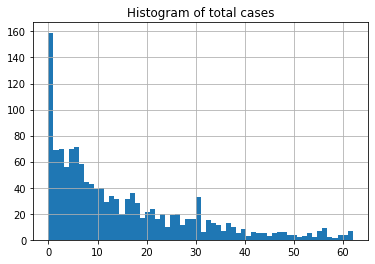

In [150]:
df_reg['total_cases'].hist(bins=60)
plt.title("Histogram of total cases")

Create a total cases attribute to choose the reliable datapoint and remove the biases like as we can see in above plot some datapoints near by 60 can be biased one

[1. 2. 3. 4. 0.]


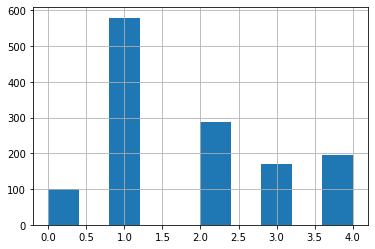

In [151]:
df_reg["total_cases_cat"]=np.ceil(df_reg["total_cases"]/10) 
df_reg["total_cases_cat"].where(df_reg["total_cases_cat"]<4,4.0,inplace=True)
df_reg["total_cases_cat"].hist()
print(df_reg["total_cases_cat"].unique())

The data is divided into following category with some percentage, the same should be there for split

In [152]:
df_reg["total_cases_cat"].value_counts()/len(df_reg) 

1.0    0.434685
2.0    0.215465
4.0    0.147147
3.0    0.127628
0.0    0.075075
Name: total_cases_cat, dtype: float64

Now split the data into 80:20 split by using stratified split method so that both train and test can have equal percentage of all categories

In [153]:
split=StratifiedShuffleSplit(n_splits=4,test_size=0.2,random_state=42) 
for train_index,test_index in split.split(df_reg,df_reg["total_cases_cat"]):
    train_set=df_reg.iloc[train_index]
    test_set=df_reg.iloc[test_index]
print(train_set["total_cases_cat"].value_counts()/len(train_set)) 
test_set["total_cases_cat"].value_counts()/len(test_set)

1.0    0.434742
2.0    0.215023
4.0    0.147418
3.0    0.127700
0.0    0.075117
Name: total_cases_cat, dtype: float64


1.0    0.434457
2.0    0.217228
4.0    0.146067
3.0    0.127341
0.0    0.074906
Name: total_cases_cat, dtype: float64

Encoding the categorical variable like city,year and weekofyear using label encoder,as it is the most efficient method, with one hot encoding and get dummies, it will create multiple column for each category and less efficient

In [154]:
le = preprocessing.LabelEncoder()
train_set['year']=le.fit_transform(train_set['year'])
test_set['year']=le.transform(test_set['year'])
train_set['city']=le.fit_transform(train_set['city'])
test_set['city']=le.transform(test_set['city'])
train_set['weekofyear']=le.fit_transform(train_set['weekofyear'])
test_set['weekofyear']=le.transform(test_set['weekofyear'])

C:\Users\18132\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\18132\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\18132\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [155]:
X_train_reg=train_set.drop(columns=['total_cases','total_cases_cat'])
X_test_reg=test_set.drop(columns=['total_cases','total_cases_cat'])
y_train_reg=train_set['total_cases']
y_test_reg=test_set['total_cases']

Did the scaling of all the columns of train and test except city,year and week of year, as they are already done while encoding, train is fit transformed and test is only transformed as it should not learn from train dataset

In [156]:
sc=StandardScaler()
X_train_reg.iloc[:,3:13]=sc.fit_transform(X_train_reg.iloc[:,3:13])
X_test_reg.iloc[:,3:13]=sc.transform(X_test_reg.iloc[:,3:13])

In [157]:
X_train_rnp=X_train_reg.to_numpy()
X_test_rnp=X_test_reg.to_numpy()
y_train_rnp=y_train_reg.to_numpy()
y_test_rnp=y_test_reg.to_numpy()

**MLP Regressor**

In [53]:
mlp_reg=MLPRegressor(hidden_layer_sizes=(100, ), activation='relu', solver='lbfgs',random_state=42)
mlp_reg.fit(X_train_rnp,y_train_rnp)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=42, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [56]:
mlp_reg1_predict=mlp_reg.predict(X_test_rnp)
print("Root Mean squared error test: %.2f" %sqrt(mean_squared_error(y_test_rnp,mlp_reg1_predict)))

Root Mean squared error test: 10.79


In [61]:
mlp_reg1=MLPRegressor(hidden_layer_sizes=(50,100), activation='relu', solver='lbfgs',random_state=42)
mlp_reg1.fit(X_train_rnp,y_train_rnp)
mlp_reg1_predict1=mlp_reg1.predict(X_test_rnp)
print("Root Mean squared error test: %.2f" %sqrt(mean_squared_error(y_test_rnp,mlp_reg1_predict1)))

Root Mean squared error test: 10.59


**4. Optional: Evaluate the model and compare it with the previous three assignments**

In [62]:
regression=pd.DataFrame(np.array([['SGD','12.33'],['Linear SVR','12.15'],['MLP Regressor','10.59']]),columns=['Model','RMSE of test data'])
regression.head()

,Model,RMSE of test data
0,SGD,12.33
1,Linear SVR,12.15
2,MLP Regressor,10.59


As we can see MLP regressor has lowest RMSE, it is the best model among all three models.

**Submission file for MLP REgressor**

In [158]:
sub_test=pd.read_csv("dengue_features_test.csv")
sub_test=sub_test.fillna(method='ffill')

In [159]:
#Encoding week of year for new test file
sub_test['weekofyear']=le.transform(sub_test['weekofyear'])
#Encoding city of new test file
train_set['city'] = le.fit_transform(train_set['city'])
sub_test['city'] = sub_test['city'].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
sub_test['city'] = le.transform(sub_test['city'])
#Encoding year of new test file
train_set['year'] = le.fit_transform(train_set['year'])
sub_test['year'] = sub_test['year'].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
sub_test['year'] = le.transform(sub_test['year'])

C:\Users\18132\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\18132\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """
C:\Users\18132\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [160]:
#renaming the columns as we did it for train data
sub_test.columns=sub_test.columns.str.replace('station','stn')
sub_test.columns=sub_test.columns.str.replace('reanalysis','re_an')
sub_test.columns=sub_test.columns.str.replace('humidity','hd')
sub_test.columns=sub_test.columns.str.replace('precipitation','prec')
sub_test.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,prec_amt_mm,re_an_air_temp_k,...,re_an_precip_amt_kg_per_m2,re_an_relative_hd_percent,re_an_sat_precip_amt_mm,re_an_specific_hd_g_per_kg,re_an_tdtr_k,stn_avg_temp_c,stn_diur_temp_rng_c,stn_max_temp_c,stn_min_temp_c,stn_precip_mm
0,2,21,17,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,2,21,18,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,2,21,19,2008-05-13,-0.0015,-0.012400,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,2,21,20,2008-05-20,-0.0015,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,2,21,21,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [161]:
#dropping the columns which we dropped for train dataset
sub_test=sub_test.drop(columns=['ndvi_ne','ndvi_se','re_an_avg_temp_k','re_an_min_air_temp_k','re_an_max_air_temp_k','stn_diur_temp_rng_c','prec_amt_mm','re_an_dew_point_temp_k','week_start_date'])
sub_test.shape

(416, 15)

In [162]:
# converting the humidity column to percentage as we did the same for train data
sub_test['re_an_relative_hd_percent']=(sub_test['re_an_relative_hd_percent']/ 100).round(2)

In [163]:
#Encoding vegetation variables
sub_test.loc[sub_test['ndvi_nw']<=0.25,'sc_ndvi_nw']=0
sub_test.loc[sub_test['ndvi_nw']>0.25,'sc_ndvi_nw']=1
sub_test.loc[sub_test['ndvi_sw']<=0.25,'sc_ndvi_sw']=0
sub_test.loc[sub_test['ndvi_sw']>0.25,'sc_ndvi_sw']=1

In [164]:
sub_test=sub_test.drop(columns=['ndvi_nw','ndvi_sw'])
sub_test.head()

,city,year,weekofyear,re_an_air_temp_k,re_an_precip_amt_kg_per_m2,re_an_relative_hd_percent,re_an_sat_precip_amt_mm,re_an_specific_hd_g_per_kg,re_an_tdtr_k,stn_avg_temp_c,stn_max_temp_c,stn_min_temp_c,stn_precip_mm,sc_ndvi_nw,sc_ndvi_sw
0,2,21,17,298.492857,25.37,0.79,78.60,15.918571,3.128571,26.528571,33.3,21.7,75.2,0.0,0.0
1,2,21,18,298.475714,21.83,0.78,12.56,15.791429,2.571429,26.071429,30.0,22.2,34.3,0.0,0.0
2,2,21,19,299.455714,4.12,0.78,3.66,16.674286,4.428571,27.928571,32.8,22.8,3.0,0.0,0.0
3,2,21,20,299.690000,2.20,0.73,0.00,15.775714,4.342857,28.057143,33.3,24.4,0.3,0.0,0.0
4,2,21,21,299.780000,4.36,0.74,0.76,16.137143,3.542857,27.614286,33.3,23.3,84.1,0.0,0.0


In [165]:
#Scaling new test data
sub_test.iloc[:,3:13]=sc.transform(sub_test.iloc[:,3:13])
sub_test_np=sub_test.to_numpy()

In [166]:
#predicting the total cases fro new test dataset using the best model i.e. linear SVR after changing the paramenters
sub_predict=mlp_reg1.predict(sub_test_np)

In [167]:
sub_test['total_cases']=sub_predict
sub_test.head()

,city,year,weekofyear,re_an_air_temp_k,re_an_precip_amt_kg_per_m2,re_an_relative_hd_percent,re_an_sat_precip_amt_mm,re_an_specific_hd_g_per_kg,re_an_tdtr_k,stn_avg_temp_c,stn_max_temp_c,stn_min_temp_c,stn_precip_mm,sc_ndvi_nw,sc_ndvi_sw,total_cases
0,2,21,17,-0.083871,-0.342414,-0.480221,0.761668,-0.517545,-0.542192,-0.492810,0.421692,-0.210982,0.666266,0.0,0.0,5.592699
1,2,21,18,-0.096662,-0.421293,-0.616568,-0.778568,-0.600315,-0.696252,-0.853920,-1.244455,0.114287,-0.136730,0.0,0.0,5.544689
2,2,21,19,0.634558,-0.815910,-0.616568,-0.986141,-0.025577,-0.182720,0.613088,0.169246,0.504610,-0.751247,0.0,0.0,5.620866
3,2,21,20,0.809369,-0.858692,-1.298300,-1.071502,-0.610545,-0.206422,0.714651,0.421692,1.545471,-0.804256,0.0,0.0,7.200822
4,2,21,21,0.876522,-0.810563,-1.161954,-1.053777,-0.375256,-0.427635,0.364825,0.421692,0.829879,0.841001,0.0,0.0,6.410383


In [168]:
submission_file=pd.read_csv("dengue_features_test.csv")
submission_file=submission_file.fillna(method='ffill')

In [169]:
submission_file['total_cases']=sub_predict
submission_file['total_cases']=submission_file['total_cases'].astype(int)
submission_file=submission_file[['city','year','weekofyear','total_cases']]

In [170]:
submission_file.to_csv(r'C:\Users\18132\Desktop\My Docs\DSP\Ass_4\submission_file.csv', index = False)

**5.Add a new column called 'above_average' with value 1 or 0. 1 if the total_cases > median of total_cases**

In [93]:
df_class=df_sel
df_class.loc[df_class['total_cases']<=np.median(df_class['total_cases']),'above_average']=0
df_class.loc[df_class['total_cases']>np.median(df_class['total_cases']),'above_average']=1

In [95]:
np.median(df_class['total_cases'])

10.0

In [96]:
df_class.loc[10:15,:]

,city,year,weekofyear,re_an_air_temp_k,re_an_precip_amt_kg_per_m2,re_an_relative_hd_percent,re_an_sat_precip_amt_mm,re_an_specific_hd_g_per_kg,re_an_tdtr_k,stn_avg_temp_c,stn_max_temp_c,stn_min_temp_c,stn_precip_mm,total_cases,sc_ndvi_nw,sc_ndvi_sw,above_average
10,sj,1990,28,299.512857,43.72,0.81,22.27,17.418571,2.157143,27.557143,31.7,21.7,63.7,8,0.0,0.0,0.0
11,sj,1990,29,299.667143,40.90,0.82,59.17,17.737143,2.414286,28.128571,32.8,23.9,12.2,2,0.0,1.0,0.0
12,sj,1990,30,299.558571,42.53,0.81,16.48,17.341429,2.071429,28.114286,31.7,22.8,32.6,6,0.0,0.0,0.0
13,sj,1990,31,299.862857,34.60,0.81,32.66,17.594286,2.585714,28.242857,34.4,22.8,37.6,17,0.0,1.0,1.0
14,sj,1990,32,300.391429,20.00,0.80,28.80,17.950000,2.328571,28.200000,33.3,23.3,11.4,23,0.0,0.0,1.0
15,sj,1990,33,299.958571,101.90,0.84,90.75,18.515714,1.857143,28.042857,32.8,22.8,44.7,13,0.0,0.0,1.0


In [97]:
df_class=df_class.drop(columns=['total_cases'])

**6. Build a Neural Network MLP Classifier on the 'above_average' column with 80/20 train/test split**

In [99]:
#Split generation
train_class,test_class= train_test_split(df_class,test_size=0.2)
print(train_class.shape)
test_class.shape

(1065, 16)


(267, 16)

In [100]:
#Encoding the categorical variables
le1 = preprocessing.LabelEncoder()
train_class['year']=le1.fit_transform(train_class['year'])
test_class['year']=le1.transform(test_class['year'])
train_class['city']=le1.fit_transform(train_class['city'])
test_class['city']=le1.transform(test_class['city'])
train_class['weekofyear']=le1.fit_transform(train_class['weekofyear'])
test_class['weekofyear']=le1.transform(test_class['weekofyear'])

C:\Users\18132\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\18132\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\18132\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [101]:
train_class.head()

,city,year,weekofyear,re_an_air_temp_k,re_an_precip_amt_kg_per_m2,re_an_relative_hd_percent,re_an_sat_precip_amt_mm,re_an_specific_hd_g_per_kg,re_an_tdtr_k,stn_avg_temp_c,stn_max_temp_c,stn_min_temp_c,stn_precip_mm,sc_ndvi_nw,sc_ndvi_sw,above_average
1327,0,18,1,296.095714,62.61,0.95,71.84,16.681429,5.100000,25.800000,31.4,22.6,104.4,1.0,1.0,1.0
638,1,12,31,301.002857,9.36,0.78,39.52,18.201429,3.514286,28.471429,32.2,25.0,3.6,0.0,1.0,0.0
559,1,11,4,297.972857,32.36,0.79,23.78,15.378571,2.742857,25.242857,30.6,21.1,21.6,0.0,0.0,1.0
665,1,13,6,298.370000,33.60,0.80,68.17,15.914286,2.328571,25.400000,29.4,21.7,37.1,0.0,0.0,0.0
1350,0,18,24,296.742857,57.87,0.96,111.18,17.447143,6.957143,26.900000,31.1,21.0,79.8,0.0,0.0,0.0


In [102]:
test_class.head()

,city,year,weekofyear,re_an_air_temp_k,re_an_precip_amt_kg_per_m2,re_an_relative_hd_percent,re_an_sat_precip_amt_mm,re_an_specific_hd_g_per_kg,re_an_tdtr_k,stn_avg_temp_c,stn_max_temp_c,stn_min_temp_c,stn_precip_mm,sc_ndvi_nw,sc_ndvi_sw,above_average
555,1,11,0,298.477143,1.30,0.77,0.00,15.444286,3.285714,25.128571,30.0,20.6,1.9,0.0,0.0,1.0
188,1,3,48,298.218571,43.40,0.80,5.29,15.932857,2.357143,26.528571,30.6,21.1,20.8,0.0,0.0,1.0
385,1,7,38,300.420000,39.60,0.79,13.18,17.828571,2.400000,28.400000,32.2,23.9,25.4,0.0,0.0,1.0
219,1,4,27,299.481429,18.52,0.77,9.77,16.502857,2.128571,28.171429,32.2,23.9,28.7,0.0,0.0,1.0
1388,0,19,10,297.058571,108.83,0.98,97.80,18.352857,6.028571,27.300000,33.8,21.0,0.0,0.0,0.0,1.0


In [103]:
#Creating independent and dependent variables
X_train_class=train_class.drop(columns=['above_average'])
y_train_class=train_class['above_average']
X_test_class=test_class.drop(columns=['above_average'])
y_test_class=test_class['above_average']

In [105]:
#Scaling the variables for model
sc1=StandardScaler()
X_train_class.iloc[:,3:13]=sc1.fit_transform(X_train_class.iloc[:,3:13])
X_test_class.iloc[:,3:13]=sc1.transform(X_test_class.iloc[:,3:13])

In [106]:
X_train_cnp=X_train_class.to_numpy()
X_test_cnp=X_test_class.to_numpy()
y_train_cnp=y_train_class.to_numpy()
y_test_cnp=y_test_class.to_numpy()

In [108]:
#Default settings create 1 hidden layer with 100 neurons
#look at MLPClassifier documentation in sklearn to see which parameters can be modified
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,))
mlp_clf.fit(X_train_cnp, y_train_cnp)

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [109]:
predict_class1 = mlp_clf.predict(X_test_cnp)

In [112]:
#Confusion matrix for first MLP
confusion_matrix(y_test_cnp, predict_class1)

array([[101,  32],
       [ 26, 108]], dtype=int64)

In [175]:
y_test_class.value_counts()

1.0    134
0.0    133
Name: above_average, dtype: int64

Class:
0: Number of cases less than or equal to 10 i.e. median of total cases of dengue

1: Number of cases more than to 10 i.e. median of total cases of dengue

According to above confusion matrix:

It has predicted 0 class correctly 101 times nad wrong 32 times

It has predicted 1 class correctly 108 times and wrong 26 times

In [130]:
# MLP with changed parameters
mlp_clf1 = MLPClassifier(hidden_layer_sizes=(50,),activation='logistic',random_state=42)
mlp_clf1.fit(X_train_cnp, y_train_cnp)
predict_class2 = mlp_clf1.predict(X_test_cnp)
confusion_matrix(y_test_cnp, predict_class2)

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([[105,  28],
       [ 26, 108]], dtype=int64)

Class:
0: Number of cases less than or equal to 10 i.e. median of total cases of dengue

1: Number of cases more than to 10 i.e. median of total cases of dengue

According to above confusion matrix:

It has predicted 0 class correctly 105 times nad wrong 28 times

It has predicted 1 class correctly 108 times and wrong 26 times

In [133]:
print('Precision score of first MLP classifier:%.2f'%precision_score(y_test_cnp, predict_class1))
print('Precision score of second MLP classifier:%.2f'%precision_score(y_test_cnp, predict_class2))

Precision score of first MLP classifier:0.77
Precision score of second MLP classifier:0.79


In [134]:
print('Recall score of first MLP classifier:%.2f'%recall_score(y_test_cnp, predict_class1))
print('Recall score of second MLP classifier:%.2f'%recall_score(y_test_cnp, predict_class2))

Recall score of first MLP classifier:0.81
Recall score of second MLP classifier:0.81


In [135]:
print('F1 score of first MLP classifier:%.2f'%f1_score(y_test_cnp, predict_class1))
print('F1 score of second MLP classifier:%.2f'%f1_score(y_test_cnp, predict_class2))

F1 score of first MLP classifier:0.79
F1 score of second MLP classifier:0.80


So, we can say, second model is better than first, as, it predicted 0 class better. Also the F1 score and precision score for it is better.

**7. Explain the meaning of Precision, Recall and F1-Score and why these are used to evaluate Classification models (instead of using Accuracy as a metric). Evaluate the classifier using Precision, Recall and F1 score values**

**Precision score:** It helps us to know how well the model predicted the values of classes out of total predicted values

**Recall score:** It helps us to know how well the model predicted the values of classes out of total actual values

**F1 score:** F1 score is the harmoninc mean of precision and recall, it helps us to assess the model based on single score, when we are unable to assess it based on precision or recall independently.
For example, if one algorithm has higher precision but lower recall than other or vice-versa, how can you tell which algorithm is better, so in such cases, we use F1 score

If we have unbalanced data, then accuracy will be higher, as it is more inclined towards class with more observation, so in that case, will false assess the classifier as good one and we should use the other scores like precision, recall or F1, as it depends on predicted values with actual values or total predicted values and not biased towards one class.